# データセットなど

In [4]:
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
import numpy as np
from sklearn.decomposition import PCA
from torch import nn
import types
import matplotlib.pyplot as plt
from torch.func import jacrev, vmap
from torch.utils.data import DataLoader
from scipy.stats import linregress
import random

class MyDataset():
    dataset_dict = {
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar10_12': torchvision.datasets.CIFAR10,  # airplane, automobile
        'cifar10_34': torchvision.datasets.CIFAR10,  # bird, cat
        'cifar10_56': torchvision.datasets.CIFAR10,  # deer, dog
    }

    def __init__(self, dataset_name, data_dir=None, classes=None, binarize=False, binarize_images=False, format='NCHW', pca_dims=None, max_features=1000, standardization=False):
        self.name = dataset_name
        self.pca_dims = pca_dims
        self.binarize_images = binarize_images
        self.standardization = standardization

        def standardize(X):
            mean = np.mean(X, axis=0, keepdims=True)
            std = np.std(X, axis=0, keepdims=True)
            std[std == 0] = 1
            return (X - mean) / std

        def format_data(dataset):
            X, y = dataset.data, dataset.targets

            if self.name == 'cifar10':
                X = X.reshape(len(X), -1)
            elif self.name == 'cifar10_12':
                mask = np.isin(y, [0, 1])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 1).astype(int)
                X = X.reshape(len(X), -1)
            elif self.name == 'cifar10_34':
                mask = np.isin(y, [2, 3])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 3).astype(int)
                X = X.reshape(len(X), -1)
            elif self.name == 'cifar10_56':
                mask = np.isin(y, [4, 5])
                X, y = X[mask], np.array(y)[mask]
                y = (y == 5).astype(int)
                X = X.reshape(len(X), -1)

            if format == 'NHWC':
                X = X.transpose(0, 2, 3, 1)

            if self.standardization:
                X = X.reshape(len(X), -1)
                X = standardize(X)
                X = X.reshape(len(X), -1, 1, 1)
            else:
                X = X / 255.0

            if self.binarize_images:
                X = np.where(X < 0.5, -1, 1)

            n_classes = int(max(y)) + 1
            if classes is not None:
                converter = -1 * np.ones(n_classes)
                for new_class, group in enumerate(classes):
                    group = [group] if type(group) == int else group
                    for old_class in group:
                        converter[old_class] = new_class
                mask = (converter[y] >= 0)
                X = X[mask]
                y = converter[y][mask]
                n_classes = int(max(y)) + 1

            if n_classes == 2 and binarize:
                y = 2 * y - 1
                y = y[:, None]
            else:
                y = F.one_hot(torch.Tensor(y).long()).numpy()

            if self.pca_dims:
                X = X.reshape(len(X), -1)
                pca = PCA(n_components=self.pca_dims)
                X = pca.fit_transform(X)
                X = X.reshape(len(X), self.pca_dims, 1, 1)

            return X.astype(np.float32), y.astype(np.float32)

        transform = transforms.Compose([transforms.ToTensor()])
        raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True, transform=transform)
        raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True, transform=transform)

        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train", rng=None, class_eq=False):
        n = int(n)
        assert n > 0, "データセットのサイズは正の整数"
        assert get in ["train", "test"], "'get'は'train'または'test'を指定"

        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)

        if rng is None:
            rng = np.random.default_rng()

        if class_eq:
            n_classes = full_y.shape[1]
            class_indices = [np.where(full_y[:, i] == 1)[0] for i in range(n_classes)]

            samples_per_class = n // n_classes
            remainder = n % n_classes
            indices = []

            for i, class_idx in enumerate(class_indices):
                n_samples = samples_per_class + (1 if i < remainder else 0)
                selected_indices = rng.choice(class_idx, size=n_samples, replace=False)
                indices.extend(selected_indices)

            rng.shuffle(indices)
        else:
            indices = rng.permutation(len(full_X))[:n]

        X, y = full_X[indices].copy(), full_y[indices].copy()

        assert len(X) == n, "サンプリングされたデータのサイズが期待と異なる"

        return X, y


#############################################################################################

class CustomDataLoader:
    def __init__(self, X, y, batch_size, shuffle, **kwargs):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset = torch.utils.data.TensorDataset(self.X, self.y)

    def __iter__(self):
        num_batches = len(self.X) // self.batch_size
        indices = torch.randperm(len(self.X)) if self.shuffle else torch.arange(len(self.X))

        for i in range(num_batches):
            batch_indices = indices[i * self.batch_size:(i + 1) * self.batch_size]
            X_batch = self.X[batch_indices]
            y_batch = self.y[batch_indices]
            yield X_batch, y_batch

class BalancedDataLoader(CustomDataLoader):
    def __init__(self, X, y, batch_size, shuffle=True, **kwargs):
        super().__init__(X, y, batch_size, shuffle, **kwargs)
        self.class_indices = {i: torch.where(torch.argmax(y, dim=1) == i)[0] for i in range(y.shape[1])}
        self.num_classes = len(self.class_indices)

    def __iter__(self):
        if self.batch_size == 1:
            indices = torch.randperm(len(self.X)) if self.shuffle else torch.arange(len(self.X))
            for i in range(len(self.X)):
                yield self.X[indices[i:i + 1]], self.y[indices[i:i + 1]]
        else:
            class_batch_size = max(1, self.batch_size // self.num_classes)
            min_class_size = min(len(indices) for indices in self.class_indices.values())
            total_batches = max(1, min_class_size // class_batch_size)

            for _ in range(total_batches):
                batch_indices = []
                for class_idx, indices in self.class_indices.items():
                    if self.shuffle:
                        selected_indices = indices[torch.randperm(len(indices))[:class_batch_size]]
                    else:
                        selected_indices = indices[:class_batch_size]
                    batch_indices.append(selected_indices)

                selected_batch_indices = torch.cat(batch_indices)
                X_batch = self.X[selected_batch_indices]
                y_batch = self.y[selected_batch_indices]
                yield X_batch, y_batch

def train_error(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            output, _, _, _, _, _, _, _, _, _, _, _ = model(data)
            train_loss += F.mse_loss(output, target, reduction='sum').item() / target.shape[1]
            pred = output.argmax(dim=1)
            correct += (pred == target.argmax(dim=1)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return train_loss, accuracy

def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output, _, _, _, _, _, _, _, _, _, _, _ = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred == target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Spectral Parametrization

## Constant Ratio

In [5]:
class MLP(nn.Module):
    def __init__(self, d_in, d_out, n1, n2, n3, n4, n5, r_value):
        super().__init__()

        # g1, g2, g3, g4, g5, g6 の計算
        activity1 = n1 ** r_value
        activity2 = n2 ** r_value
        activity3 = n3 ** r_value
        activity4 = n4 ** r_value
        activity5 = n5 ** r_value
        activity6 = 1.0 ** r_value

        self.activity1 = activity1
        self.activity2 = activity2
        self.activity3 = activity3
        self.activity4 = activity4
        self.activity5 = activity5
        self.activity6 = activity6
        self.n1, self.n2, self.n3, self.n4, self.n5 = n1, n2, n3, n4, n5

        self.g1 = activity1 / torch.sqrt(torch.tensor(d_in, dtype=torch.float32))
        self.g2 = activity2 / torch.sqrt(torch.tensor(n1, dtype=torch.float32))
        self.g3 = activity3 / torch.sqrt(torch.tensor(n2, dtype=torch.float32))
        self.g4 = activity4 / torch.sqrt(torch.tensor(n3, dtype=torch.float32))
        self.g5 = activity5 / torch.sqrt(torch.tensor(n4, dtype=torch.float32))
        self.g6 = torch.sqrt(torch.tensor(1.0, dtype=torch.float32)) / torch.sqrt(torch.tensor(n5, dtype=torch.float32))

        # 各層の重み行列
        self.fc1 = nn.Linear(d_in, n1, bias=False)
        self.fc2 = nn.Linear(n1, n2, bias=False)
        self.fc3 = nn.Linear(n2, n3, bias=False)
        self.fc4 = nn.Linear(n3, n4, bias=False)
        self.fc5 = nn.Linear(n4, n5, bias=False)
        self.fc6 = nn.Linear(n5, d_out, bias=False)

        self.gamma = torch.sqrt(torch.tensor(2.0))

        # 重みを個別に初期化
        nn.init.normal_(self.fc1.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc2.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc3.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc4.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc5.weight, 0, std=self.gamma / activity5)
        nn.init.normal_(self.fc6.weight, 0, std=1 / activity5)

        self.act = nn.ReLU()
        # self.act = nn.GELU()

    def forward(self, x):
        h1_pre = self.g1 * self.fc1(x)
        h1_post = self.act(h1_pre)

        h2_pre = self.g2 * self.fc2(h1_post)
        h2_post = self.act(h2_pre)

        h3_pre = self.g3 * self.fc3(h2_post)
        h3_post = self.act(h3_pre)

        h4_pre = self.g4 * self.fc4(h3_post)
        h4_post = self.act(h4_pre)

        h5_pre = self.g5 * self.fc5(h4_post)
        h5_post = self.act(h5_pre)

        h6_pre = self.g6 * self.fc6(h5_post)
        output = h6_pre

        return output, h1_pre, h1_post, h2_pre, h2_post, h3_pre, h3_post, h4_pre, h4_post, h5_pre, h5_post, h6_pre


###### 実験設定
################################
# 試行回数
ntrials = 30

# モデル
d_in = 3072
d_out = 2
r_value = 0.5
ns = np.logspace(np.log10(1000), np.log10(10000), num=10, dtype=int)
ns_n_min = np.logspace(np.log10(1000), np.log10(5000), num=10, dtype=int)

# 学習
nepochs = 1
learn_rate = 0.1
momentum = 0.0
weight_decay = 0.0

# データ
class_eq= True
train_size = 2000
test_size = 1
batch_size = 1

results = np.empty((6, len(ns), ntrials, nepochs))
################################

data = MyDataset("cifar10_12", 'data', binarize_images=False, standardization=False)
X_train, y_train = data.get_dataset(train_size, get='train', class_eq=class_eq)
X_test, y_test = data.get_dataset(test_size, get='test', class_eq=class_eq)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = [torch.Tensor(d).to(device) for d in (X_train, y_train, X_test, y_test)]

train_loader = BalancedDataLoader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = BalancedDataLoader(X_test, y_test, batch_size=batch_size, shuffle=False)

for i, (n, n_min) in enumerate(zip(ns, ns_n_min)):
    for trial in range(ntrials):
        if trial % 100 == 0:
            print(f"Trial {trial + 1}/{ntrials}, n {n}/{ns[-1]}")
        model = MLP(d_in=d_in, d_out=d_out, n1=n, n2=int(n*0.2), n3=n, n4=int(n*0.2), n5=n, r_value=r_value).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(nepochs):
            model.train()

            # 中間層の出力に対して勾配を保持する設定
            def save_intermediate_grad(module, input, output):
                output.retain_grad()  # 出力の勾配を保持する

            model.fc1.register_forward_hook(save_intermediate_grad)
            model.fc2.register_forward_hook(save_intermediate_grad)
            model.fc3.register_forward_hook(save_intermediate_grad)
            model.fc4.register_forward_hook(save_intermediate_grad)
            model.fc5.register_forward_hook(save_intermediate_grad)
            model.fc6.register_forward_hook(save_intermediate_grad)

            data, target = next(iter(train_loader))
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output, old_h1_pre, old_h1_post, old_h2_pre, old_h2_post, old_h3_pre, old_h3_post, old_h4_pre, old_h4_post, old_h5_pre, old_h5_post, old_h6 = model(data)

            old_fc1 = model.fc1.weight.detach().clone()
            old_fc2 = model.fc2.weight.detach().clone()
            old_fc3 = model.fc3.weight.detach().clone()
            old_fc4 = model.fc4.weight.detach().clone()
            old_fc5 = model.fc5.weight.detach().clone()
            old_fc6 = model.fc6.weight.detach().clone()

            old_h1_pre.retain_grad()
            old_h1_post.retain_grad()
            old_h2_pre.retain_grad()
            old_h2_post.retain_grad()
            old_h3_pre.retain_grad()
            old_h3_post.retain_grad()
            old_h4_pre.retain_grad()
            old_h4_post.retain_grad()
            old_h5_pre.retain_grad()
            old_h5_post.retain_grad()
            old_h6.retain_grad()

            loss = F.mse_loss(output, target)
            loss.backward()

            old_h1_pre_grad = old_h1_pre.grad
            old_h2_pre_grad = old_h2_pre.grad
            old_h3_pre_grad = old_h3_pre.grad
            old_h4_pre_grad = old_h4_pre.grad
            old_h5_pre_grad = old_h5_pre.grad
            old_h6_grad = old_h6.grad

            optimizer.step()

            _, new_h1_pre, new_h1_post, new_h2_pre, new_h2_post, new_h3_pre, new_h3_post, new_h4_pre, new_h4_post, new_h5_pre, new_h5_post, new_h6 = model(data)

            new_fc1 = model.fc1.weight.detach().clone()
            new_fc2 = model.fc2.weight.detach().clone()
            new_fc3 = model.fc3.weight.detach().clone()
            new_fc4 = model.fc4.weight.detach().clone()
            new_fc5 = model.fc5.weight.detach().clone()
            new_fc6 = model.fc6.weight.detach().clone()

            update_h1_pre = new_h1_pre - old_h1_pre
            update_h2_pre = new_h2_pre - old_h2_pre
            update_h3_pre = new_h3_pre - old_h3_pre
            update_h4_pre = new_h4_pre - old_h4_pre
            update_h5_pre = new_h5_pre - old_h5_pre
            update_h6 = new_h6 - old_h6

            update_h1_post = new_h1_post - old_h1_post
            update_h2_post = new_h2_post - old_h2_post
            update_h3_post = new_h3_post - old_h3_post
            update_h4_post = new_h4_post - old_h4_post
            update_h5_post = new_h5_post - old_h5_post
            update_h6_post = new_h6 - old_h6

            update_fc1 = new_fc1 - old_fc1
            update_fc2 = new_fc2 - old_fc2
            update_fc3 = new_fc3 - old_fc3
            update_fc4 = new_fc4 - old_fc4
            update_fc5 = new_fc5 - old_fc5
            update_fc6 = new_fc6 - old_fc6

            scale_h1_pre = torch.norm(update_h1_pre, p=2, dim=1)
            scale_h2_pre = torch.norm(update_h2_pre, p=2, dim=1)
            scale_h3_pre = torch.norm(update_h3_pre, p=2, dim=1)
            scale_h4_pre = torch.norm(update_h4_pre, p=2, dim=1)
            scale_h5_pre = torch.norm(update_h5_pre, p=2, dim=1)
            scale_h6 = torch.norm(update_h6, p=2, dim=1)

            scale_h1_pre = torch.abs(torch.sum(update_h1_pre * (old_h1_pre_grad), dim=1))
            scale_h2_pre = torch.abs(torch.sum(update_h2_pre * (old_h2_pre_grad), dim=1))
            scale_h3_pre = torch.abs(torch.sum(update_h3_pre * (old_h3_pre_grad), dim=1))
            scale_h4_pre = torch.abs(torch.sum(update_h4_pre * (old_h4_pre_grad), dim=1))
            scale_h5_pre = torch.abs(torch.sum(update_h5_pre * (old_h5_pre_grad), dim=1))
            scale_h6 = torch.abs(torch.sum(update_h6 * (old_h6_grad), dim=1))

            results[0, i, trial, epoch] = scale_h1_pre.mean().item()
            results[1, i, trial, epoch] = scale_h2_pre.mean().item()
            results[2, i, trial, epoch] = scale_h3_pre.mean().item()
            results[3, i, trial, epoch] = scale_h4_pre.mean().item()
            results[4, i, trial, epoch] = scale_h5_pre.mean().item()
            results[5, i, trial, epoch] = scale_h6.mean().item()

mean_scale1 = {
    "h1_init": results[0, :, :, 0].mean(axis=1),
    "h2_init": results[1, :, :, 0].mean(axis=1),
    "h3_init": results[2, :, :, 0].mean(axis=1),
    "h4_init": results[3, :, :, 0].mean(axis=1),
    "h5_init": results[4, :, :, 0].mean(axis=1),
    "h6_init": results[5, :, :, 0].mean(axis=1),
}
std_scale1 = {
    "h1_init": results[0, :, :, 0].std(axis=1),
    "h2_init": results[1, :, :, 0].std(axis=1),
    "h3_init": results[2, :, :, 0].std(axis=1),
    "h4_init": results[3, :, :, 0].std(axis=1),
    "h5_init": results[4, :, :, 0].std(axis=1),
    "h6_init": results[5, :, :, 0].std(axis=1),
}

mean_values1 = {key: val.mean() for key, val in mean_scale1.items()}

Files already downloaded and verified
Files already downloaded and verified
Trial 1/30, n 1000/10000
Trial 1/30, n 1291/10000
Trial 1/30, n 1668/10000
Trial 1/30, n 2154/10000
Trial 1/30, n 2782/10000
Trial 1/30, n 3593/10000
Trial 1/30, n 4641/10000
Trial 1/30, n 5994/10000
Trial 1/30, n 7742/10000
Trial 1/30, n 10000/10000


## Dynamic Ratio

In [6]:
class MLP(nn.Module):
    def __init__(self, d_in, d_out, n1, n2, n3, n4, n5, r_value):
        super().__init__()

        # g1, g2, g3, g4, g5, g6 の計算
        activity1 = n1 ** r_value
        activity2 = n2 ** r_value
        activity3 = n3 ** r_value
        activity4 = n4 ** r_value
        activity5 = n5 ** r_value
        activity6 = 1.0 ** r_value

        self.activity1 = activity1
        self.activity2 = activity2
        self.activity3 = activity3
        self.activity4 = activity4
        self.activity5 = activity5
        self.activity6 = activity6
        self.n1, self.n2, self.n3, self.n4, self.n5 = n1, n2, n3, n4, n5

        self.g1 = activity1 / torch.sqrt(torch.tensor(d_in, dtype=torch.float32))
        self.g2 = activity2 / torch.sqrt(torch.tensor(n1, dtype=torch.float32))
        self.g3 = activity3 / torch.sqrt(torch.tensor(n2, dtype=torch.float32))
        self.g4 = activity4 / torch.sqrt(torch.tensor(n3, dtype=torch.float32))
        self.g5 = activity5 / torch.sqrt(torch.tensor(n4, dtype=torch.float32))
        self.g6 = torch.sqrt(torch.tensor(1.0, dtype=torch.float32)) / torch.sqrt(torch.tensor(n5, dtype=torch.float32))

        # 各層の重み行列
        self.fc1 = nn.Linear(d_in, n1, bias=False)
        self.fc2 = nn.Linear(n1, n2, bias=False)
        self.fc3 = nn.Linear(n2, n3, bias=False)
        self.fc4 = nn.Linear(n3, n4, bias=False)
        self.fc5 = nn.Linear(n4, n5, bias=False)
        self.fc6 = nn.Linear(n5, d_out, bias=False)

        self.gamma = torch.sqrt(torch.tensor(2.0))

        # 重みを個別に初期化
        nn.init.normal_(self.fc1.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc2.weight, 0, std=self.gamma / activity1)
        nn.init.normal_(self.fc3.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc4.weight, 0, std=self.gamma / activity3)
        nn.init.normal_(self.fc5.weight, 0, std=self.gamma / activity5)
        nn.init.normal_(self.fc6.weight, 0, std=1 / activity5)

        self.act = nn.ReLU()
        # self.act = nn.GELU()

    def forward(self, x):
        h1_pre = self.g1 * self.fc1(x)
        h1_post = self.act(h1_pre)

        h2_pre = self.g2 * self.fc2(h1_post)
        h2_post = self.act(h2_pre)

        h3_pre = self.g3 * self.fc3(h2_post)
        h3_post = self.act(h3_pre)

        h4_pre = self.g4 * self.fc4(h3_post)
        h4_post = self.act(h4_pre)

        h5_pre = self.g5 * self.fc5(h4_post)
        h5_post = self.act(h5_pre)

        h6_pre = self.g6 * self.fc6(h5_post)
        output = h6_pre

        return output, h1_pre, h1_post, h2_pre, h2_post, h3_pre, h3_post, h4_pre, h4_post, h5_pre, h5_post, h6_pre


###### 実験設定
################################
# 試行回数
ntrials = 30

# モデル
d_in = 3072
d_out = 2
r_value = 0.5
ns = np.logspace(np.log10(1000), np.log10(10000), num=10, dtype=int)
ns_n_min = np.logspace(np.log10(1000), np.log10(5000), num=10, dtype=int)

# 学習
nepochs = 1
learn_rate = 0.1
momentum = 0.0
weight_decay = 0.0

# データ
class_eq= True
train_size = 2000
test_size = 1
batch_size = 1

results = np.empty((6, len(ns), ntrials, nepochs))
################################

data = MyDataset("cifar10_12", 'data', binarize_images=False, standardization=False)
X_train, y_train = data.get_dataset(train_size, get='train', class_eq=class_eq)
X_test, y_test = data.get_dataset(test_size, get='test', class_eq=class_eq)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = [torch.Tensor(d).to(device) for d in (X_train, y_train, X_test, y_test)]

train_loader = BalancedDataLoader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = BalancedDataLoader(X_test, y_test, batch_size=batch_size, shuffle=False)

for i, (n, n_min) in enumerate(zip(ns, ns_n_min)):
    for trial in range(ntrials):
        if trial % 100 == 0:
            print(f"Trial {trial + 1}/{ntrials}, n {n}/{ns[-1]}")
        model = MLP(d_in=d_in, d_out=d_out, n1=n, n2=int(6 * (n ** 0.5)), n3=n, n4=int(6 * (n ** 0.5)), n5=n, r_value=r_value).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(nepochs):
            model.train()

            # 中間層の出力に対して勾配を保持する設定
            def save_intermediate_grad(module, input, output):
                output.retain_grad()  # 出力の勾配を保持する

            model.fc1.register_forward_hook(save_intermediate_grad)
            model.fc2.register_forward_hook(save_intermediate_grad)
            model.fc3.register_forward_hook(save_intermediate_grad)
            model.fc4.register_forward_hook(save_intermediate_grad)
            model.fc5.register_forward_hook(save_intermediate_grad)
            model.fc6.register_forward_hook(save_intermediate_grad)

            data, target = next(iter(train_loader))
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output, old_h1_pre, old_h1_post, old_h2_pre, old_h2_post, old_h3_pre, old_h3_post, old_h4_pre, old_h4_post, old_h5_pre, old_h5_post, old_h6 = model(data)

            old_fc1 = model.fc1.weight.detach().clone()
            old_fc2 = model.fc2.weight.detach().clone()
            old_fc3 = model.fc3.weight.detach().clone()
            old_fc4 = model.fc4.weight.detach().clone()
            old_fc5 = model.fc5.weight.detach().clone()
            old_fc6 = model.fc6.weight.detach().clone()

            old_h1_pre.retain_grad()
            old_h1_post.retain_grad()
            old_h2_pre.retain_grad()
            old_h2_post.retain_grad()
            old_h3_pre.retain_grad()
            old_h3_post.retain_grad()
            old_h4_pre.retain_grad()
            old_h4_post.retain_grad()
            old_h5_pre.retain_grad()
            old_h5_post.retain_grad()
            old_h6.retain_grad()

            loss = F.mse_loss(output, target)
            loss.backward()

            old_h1_pre_grad = old_h1_pre.grad
            old_h2_pre_grad = old_h2_pre.grad
            old_h3_pre_grad = old_h3_pre.grad
            old_h4_pre_grad = old_h4_pre.grad
            old_h5_pre_grad = old_h5_pre.grad
            old_h6_grad = old_h6.grad

            optimizer.step()

            _, new_h1_pre, new_h1_post, new_h2_pre, new_h2_post, new_h3_pre, new_h3_post, new_h4_pre, new_h4_post, new_h5_pre, new_h5_post, new_h6 = model(data)

            new_fc1 = model.fc1.weight.detach().clone()
            new_fc2 = model.fc2.weight.detach().clone()
            new_fc3 = model.fc3.weight.detach().clone()
            new_fc4 = model.fc4.weight.detach().clone()
            new_fc5 = model.fc5.weight.detach().clone()
            new_fc6 = model.fc6.weight.detach().clone()

            update_h1_pre = new_h1_pre - old_h1_pre
            update_h2_pre = new_h2_pre - old_h2_pre
            update_h3_pre = new_h3_pre - old_h3_pre
            update_h4_pre = new_h4_pre - old_h4_pre
            update_h5_pre = new_h5_pre - old_h5_pre
            update_h6 = new_h6 - old_h6

            update_h1_post = new_h1_post - old_h1_post
            update_h2_post = new_h2_post - old_h2_post
            update_h3_post = new_h3_post - old_h3_post
            update_h4_post = new_h4_post - old_h4_post
            update_h5_post = new_h5_post - old_h5_post
            update_h6_post = new_h6 - old_h6

            update_fc1 = new_fc1 - old_fc1
            update_fc2 = new_fc2 - old_fc2
            update_fc3 = new_fc3 - old_fc3
            update_fc4 = new_fc4 - old_fc4
            update_fc5 = new_fc5 - old_fc5
            update_fc6 = new_fc6 - old_fc6

            scale_h1_pre = torch.norm(update_h1_pre, p=2, dim=1)
            scale_h2_pre = torch.norm(update_h2_pre, p=2, dim=1)
            scale_h3_pre = torch.norm(update_h3_pre, p=2, dim=1)
            scale_h4_pre = torch.norm(update_h4_pre, p=2, dim=1)
            scale_h5_pre = torch.norm(update_h5_pre, p=2, dim=1)
            scale_h6 = torch.norm(update_h6, p=2, dim=1)

            scale_h1_pre = torch.abs(torch.sum(update_h1_pre * (old_h1_pre_grad), dim=1))
            scale_h2_pre = torch.abs(torch.sum(update_h2_pre * (old_h2_pre_grad), dim=1))
            scale_h3_pre = torch.abs(torch.sum(update_h3_pre * (old_h3_pre_grad), dim=1))
            scale_h4_pre = torch.abs(torch.sum(update_h4_pre * (old_h4_pre_grad), dim=1))
            scale_h5_pre = torch.abs(torch.sum(update_h5_pre * (old_h5_pre_grad), dim=1))
            scale_h6 = torch.abs(torch.sum(update_h6 * (old_h6_grad), dim=1))

            results[0, i, trial, epoch] = scale_h1_pre.mean().item()
            results[1, i, trial, epoch] = scale_h2_pre.mean().item()
            results[2, i, trial, epoch] = scale_h3_pre.mean().item()
            results[3, i, trial, epoch] = scale_h4_pre.mean().item()
            results[4, i, trial, epoch] = scale_h5_pre.mean().item()
            results[5, i, trial, epoch] = scale_h6.mean().item()

mean_scale2 = {
    "h1_init": results[0, :, :, 0].mean(axis=1),
    "h2_init": results[1, :, :, 0].mean(axis=1),
    "h3_init": results[2, :, :, 0].mean(axis=1),
    "h4_init": results[3, :, :, 0].mean(axis=1),
    "h5_init": results[4, :, :, 0].mean(axis=1),
    "h6_init": results[5, :, :, 0].mean(axis=1),
}
std_scale2 = {
    "h1_init": results[0, :, :, 0].std(axis=1),
    "h2_init": results[1, :, :, 0].std(axis=1),
    "h3_init": results[2, :, :, 0].std(axis=1),
    "h4_init": results[3, :, :, 0].std(axis=1),
    "h5_init": results[4, :, :, 0].std(axis=1),
    "h6_init": results[5, :, :, 0].std(axis=1),
}

mean_values2 = {key: val.mean() for key, val in mean_scale2.items()}

Files already downloaded and verified
Files already downloaded and verified
Trial 1/30, n 1000/10000
Trial 1/30, n 1291/10000
Trial 1/30, n 1668/10000
Trial 1/30, n 2154/10000
Trial 1/30, n 2782/10000
Trial 1/30, n 3593/10000
Trial 1/30, n 4641/10000
Trial 1/30, n 5994/10000
Trial 1/30, n 7742/10000
Trial 1/30, n 10000/10000


# グラフ描画

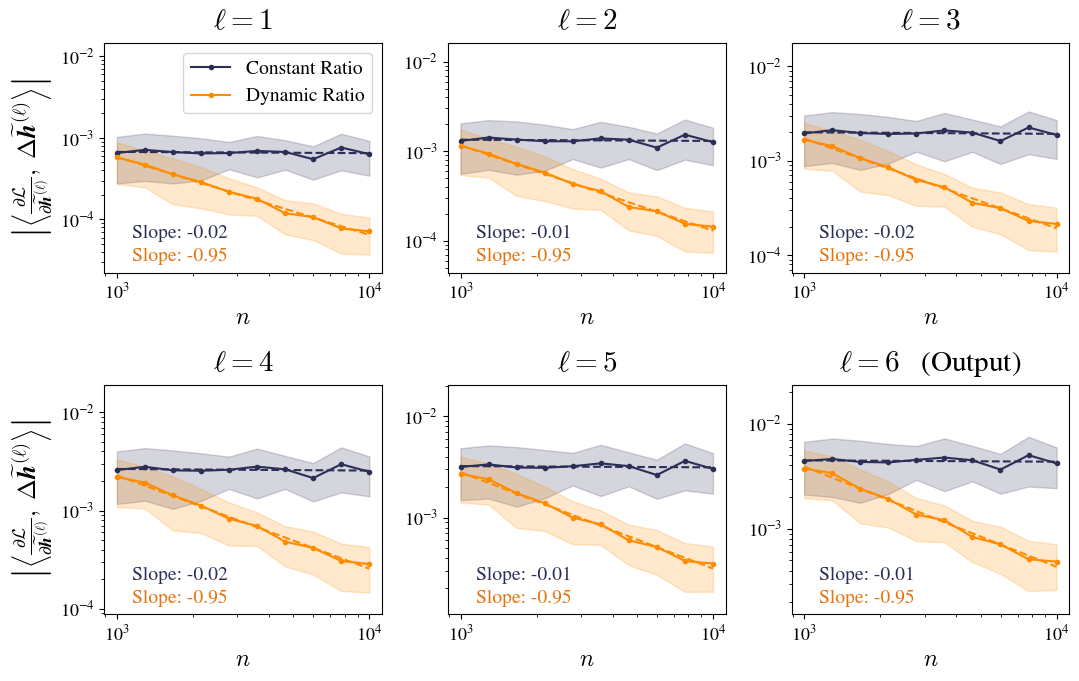

In [7]:
plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=13)
plt.rc("axes", facecolor='white', titlesize=16)
plt.rc("mathtext", fontset='cm')
plt.rc('text', usetex=False)

fig, axs = plt.subplots(2, 3, figsize=(11, 7))
axs = axs.flatten()

def calculate_slope(ns, mean):
    log_ns = np.log(ns)
    log_mean = np.log(mean)
    slope, intercept, _, _, _ = linregress(log_ns, log_mean)
    return slope, intercept

def plot_combined_scale_ratio(ax, mean1, std1, mean_val1, mean2, std2, mean_val2, ns, title, ylim,
                               show_ylabel=False, show_legend=False):
    # 1回目の実験
    slope1, intercept1 = calculate_slope(ns, mean1)
    ax.fill_between(ns, mean1 - std1, mean1 + std1, color='#2b2f57', alpha=0.2)
    ax.plot(ns, mean1, '-o', markersize=3, color='#2b2f57', label='Constant Ratio')

    # 2回目の実験
    slope2, intercept2 = calculate_slope(ns, mean2)
    ax.fill_between(ns, mean2 - std2, mean2 + std2, color='darkorange', alpha=0.2)
    ax.plot(ns, mean2, '-o', markersize=3, color='darkorange', label='Dynamic Ratio')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$n$', fontsize=17)

    if show_ylabel:
        ax.set_ylabel(r'$ \left| \left\langle { \frac{\partial \mathcal{L}}{\partial \widetilde{\boldsymbol{h}}^{(\ell)}}  }, \; \Delta \widetilde{\boldsymbol{h}}^{(\ell) } \right\rangle \right|$', fontsize=18)

    if ylim is None:
        # ymin = min(np.min(mean1 - std1), np.min(mean2 - std2)) * 1.0
        # ymax = max(np.max(mean1 + std1), np.max(mean2 + std2)) * 1.4
        ymin = min(np.min(mean1 - std1), np.min(mean2 - std2)) * 0.6
        ymax = max(np.max(mean1 + std1), np.max(mean2 + std2)) * 1.4 + 0.013
        ax.set_ylim([ymin, ymax])
    else:
        ax.set_ylim(ylim)


    # ax.grid(True)
    ax.set_title(title, fontsize=21, pad=10)

    # 傾きを表示
    ax.text(0.1, 0.15, f'Slope: {slope1:.2f}', transform=ax.transAxes, fontsize=14, color='#2b2f57')
    ax.text(0.1, 0.05, f'Slope: {slope2:.2f}', transform=ax.transAxes, fontsize=14, color='#e6730d') # #e6730d

    fitted_line1 = np.exp(intercept1) * ns ** slope1
    fitted_line2 = np.exp(intercept2) * ns ** slope2
    ax.plot(ns, fitted_line1, linestyle='--', color='#2b2f57')
    ax.plot(ns, fitted_line2, linestyle='--', color='darkorange')

    if show_legend:
        ax.legend(loc='upper right', fontsize=14)


for i in range(6):
    plot_combined_scale_ratio(
        axs[i],
        mean_scale1[f"h{i+1}_init"], std_scale1[f"h{i+1}_init"], mean_scale1[f"h{i+1}_init"].mean(),
        mean_scale2[f"h{i+1}_init"], std_scale2[f"h{i+1}_init"], mean_scale2[f"h{i+1}_init"].mean(),
        ns,
        rf"$\ell = {i+1}$" if i < 5 else rf"$\ell = {i+1}$   (Output)",
        ylim=None,
        show_ylabel=(i == 0 or i == 3),
        show_legend=(i == 0 or i == 3) and i != 3,
    )

plt.tight_layout()
plt.savefig("spectral_const_and_dynamic.pdf")
plt.show()